In [15]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

#%matplotlib inline
password = getpass.getpass()
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

········


In [42]:
query = '''SELECT film_id, title, rental_duration, rental_rate, length, rating,
        COUNT(DISTINCT rental.rental_id) AS num_rentals,
        CASE 
            WHEN MAX(rental_date) >= '2006-02-01' AND MAX(rental_date) < '2006-03-01' 
            THEN TRUE 
            ELSE FALSE 
        END AS rented_last_month
        FROM rental
        JOIN inventory USING (inventory_id)
        RIGHT JOIN film USING (film_id)
        JOIN film_category USING (film_id)
        JOIN category USING (category_id)
        GROUP BY film_id;'''

data = pd.read_sql_query(query, engine)
data.head()

,film_id,title,rental_duration,rental_rate,length,rating,num_rentals,rented_last_month
0,1,ACADEMY DINOSAUR,6,0.99,86,PG,23,0
1,2,ACE GOLDFINGER,3,4.99,48,G,7,1
2,3,ADAPTATION HOLES,7,2.99,50,NC-17,12,0
3,4,AFFAIR PREJUDICE,5,2.99,117,G,23,1
4,5,AFRICAN EGG,6,2.99,130,G,12,1


In [43]:
data

,film_id,title,rental_duration,rental_rate,length,rating,num_rentals,rented_last_month
0,1,ACADEMY DINOSAUR,6,0.99,86,PG,23,0
1,2,ACE GOLDFINGER,3,4.99,48,G,7,1
2,3,ADAPTATION HOLES,7,2.99,50,NC-17,12,0
3,4,AFFAIR PREJUDICE,5,2.99,117,G,23,1
4,5,AFRICAN EGG,6,2.99,130,G,12,1
...,...,...,...,...,...,...,...,...
995,996,YOUNG LANGUAGE,6,0.99,183,G,7,0
996,997,YOUTH KICK,4,0.99,179,NC-17,6,0
997,998,ZHIVAGO CORE,6,0.99,105,NC-17,9,1
998,999,ZOOLANDER FICTION,5,2.99,101,R,17,0


### Data Cleaning

In [44]:
data.shape

(1000, 8)

In [45]:
data.isna().sum

<bound method NDFrame._add_numeric_operations.<locals>.sum of      film_id  title  rental_duration  rental_rate  length  rating  \
0      False  False            False        False   False   False   
1      False  False            False        False   False   False   
2      False  False            False        False   False   False   
3      False  False            False        False   False   False   
4      False  False            False        False   False   False   
..       ...    ...              ...          ...     ...     ...   
995    False  False            False        False   False   False   
996    False  False            False        False   False   False   
997    False  False            False        False   False   False   
998    False  False            False        False   False   False   
999    False  False            False        False   False   False   

     num_rentals  rented_last_month  
0          False              False  
1          False              Fal

### Splitting Numerical and Categorical

In [47]:
X = data.select_dtypes(include = "number")
X_cat = data.select_dtypes(exclude = "number")


In [50]:
transformer = StandardScaler().fit(X)
x_normalised = transformer.transform(X)
x = pd.DataFrame(x_normalised)
x.columns = X.columns

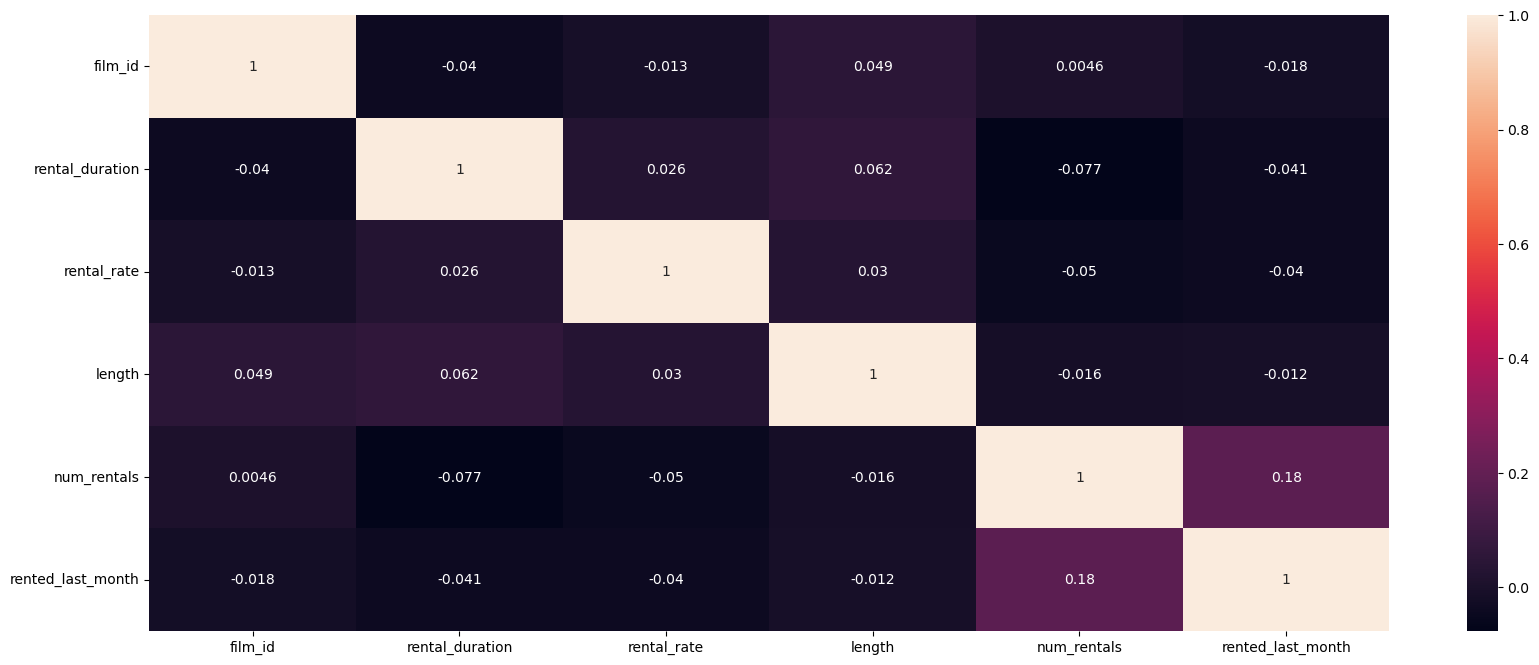

In [51]:
#visually presenting correlation matrix
corr_matrix=data.corr() 
fig, ax = plt.subplots(figsize=(20, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

### X/Y Split

In [57]:
y = data['rented_last_month']
X = pd.get_dummies(data.drop('rented_last_month', axis=1)) 

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [40]:
y

0        2005-08-02
1        2005-08-18
2        2005-06-20
3        2005-07-09
4        2005-07-30
            ...    
16039    2005-05-30
16040    2005-06-15
16041    2005-07-07
16042    2005-07-30
16043    2005-08-23
Name: rental_date, Length: 16044, dtype: object

### Logistic Regression

In [62]:
from sklearn.metrics import confusion_matrix, classification_report

In [63]:
classification = LogisticRegression(random_state=42, max_iter=10000)
classification.fit(X_train, y_train)

predictions = classification.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91       166
           1       0.00      0.00      0.00        34

    accuracy                           0.83       200
   macro avg       0.41      0.50      0.45       200
weighted avg       0.69      0.83      0.75       200



/Users/rikibravo/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rikibravo/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rikibravo/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Evaluation of Results